In [1]:
from sklearn.datasets import fetch_kddcup99
from pyspark.sql import SparkSession
from pyspark.mllib.feature import StandardScaler
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

npr.seed(536453550)
spark_seed = 80553771

spark = SparkSession.builder \
    .master("spark://localhost:7077")\
    .appName("k-meaner")\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.6') \
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.6') \
    .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.12.99') \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config('spark.hadoop.fs.s3a.access.key', '9818c1106da845c2a4fcfcab05674abd') \
    .config('spark.hadoop.fs.s3a.secret.key', '7918b4d8db2a45cc8d628c46315b62e6') \
    .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210') \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

ModuleNotFoundError: No module named 'sklearn'

In [1]:
!pip install scikit-learn

from sklearn.datasets import fetch_kddcup99
from pyspark.sql import SparkSession
from pyspark.mllib.feature import StandardScaler
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("k-meaner") \
    .config("spark.executor.memory", "512m") \
    .getOrCreate()

sc = spark.sparkContext

sc.setLogLevel("ERROR")
npr.seed(536453550)
spark_seed = 80553771


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/07/14 14:07:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the `kddcup99` dataset
G9

In [2]:
kdd = fetch_kddcup99(return_X_y=True)
n_samples = kdd[0].shape[0]

`kdd` is a tuple where the first element is an array of data points, while the second element is filled with the corresponding labels – i.e., the attack types.

In [3]:
kdd

(array([[0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        ...,
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0]], dtype=object),
 array([b'normal.', b'normal.', b'normal.', ..., b'normal.', b'normal.',
        b'normal.'], dtype=object))

In [4]:
labels = kdd[1]

Also, we save the number of unique labels; we will need this later when we choose the number of clusters for the `k-means`.

In [5]:
k = len(set(labels))

Let’s examine the distribution of attack types.

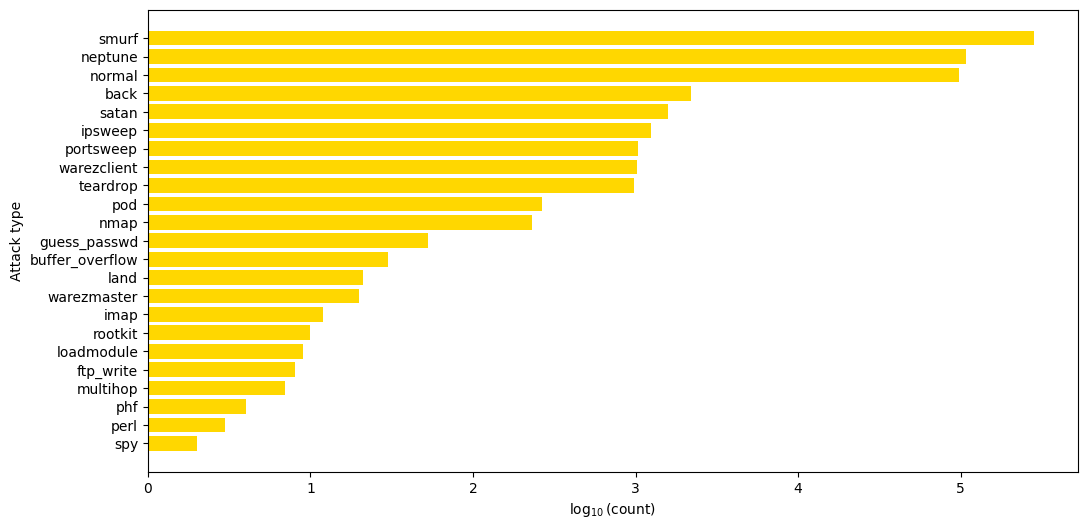

In [6]:
attacks, counts = np.unique(labels, return_counts=True)
ypos = np.arange(len(attacks))

attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

# Pre-processing

In [7]:
num_mask = [type(i) != bytes for i in kdd[0][0]]
data = kdd[0][:, num_mask]

In [8]:
n_slices = 64

kdd_rdd_raw = sc.parallelize(data, numSlices=n_slices).persist()

`StandardScaler` scales the columns to have unit standard deviation around their means.

In [9]:
scaler = StandardScaler()
scaler_model = scaler.fit(kdd_rdd_raw)
kdd_rdd_scaled = scaler_model.transform(kdd_rdd_raw)

In [10]:
# add labels and what will become the cluster-id
kdd_rdd = kdd_rdd_scaled \
    .zip(sc.parallelize(labels, numSlices=n_slices)) \
    .map(lambda x: (0, {"features": x[0].toArray(), "label": x[1]})) \
    .persist()


In [11]:
kdd_rdd.take(1)

[(0,
  {'features': array([0.00000000e+00, 1.83157948e-04, 1.64951568e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          2.81416844e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.75327100e-02,
          3.24777058e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 2.57606148e+00, 0.00000000e+00, 0.00000000e+00,
          1.39006056e-01, 8.48732827e-02, 2.43438731e+00, 0.00000000e+00,
          2.28543290e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00]),
   'label': b'normal.'})]

## `k-means` implementation

## Lloyd’s algorithm

In [12]:
def assign_to_cluster(sample, centroids):
    distances = np.sum((sample[1]["features"] - centroids)**2, axis=1) 
    # get the cluster id from the closest centroid
    cluster_id = np.argmin(distances)

    return (cluster_id, sample[1])


def k_means(rdd, centroids, max_iters):
    cost_list = [float("inf")]
    for i in range(max_iters):        
        # find the nearest centroid to each sample
        # and cache the dataset in memory for faster access
        rdd_cached = rdd \
            .map(lambda x: assign_to_cluster(x, centroids)) \
            .persist()
        
        #print(f"Iteration {i}: count {rdd_cached.countByKey()}")
        
        # update the centroids by averaging the points inside
        centroids = rdd_cached \
            .mapValues(lambda x: (x["features"], 1)) \
            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
            .mapValues(lambda x: x[0] / x[1]) \
            .values() \
            .collect()
        
        #print(f"Iteration {i}: centr {centroids}")
        
        # compute cost by summing the squared distance to the nearest cluster
        cost = rdd_cached \
            .map(lambda x: np.sum((x[1]["features"] - centroids[x[0]])**2)) \
            .reduce(lambda x, y: x + y)
        
        #print(f"Iteration {i}: cost {cost}")
        
        # break if the new cost doesn't change too much (<1%)
        # w.r.t. the previous iteration
        if cost > 0.99999 * cost_list[-1]:
            print(f"Convergence at iteration {i + 1}")
            rdd_cached.unpersist()
            break
        else:
            cost_list.append(cost)

        cost_list.append(cost)
        
        # clear the cache
        rdd_cached.unpersist()
        
    # do another half-step to return list of cluster assignments
    final_rdd = rdd.map(lambda x: assign_to_cluster(x, centroids))
        
    return final_rdd, centroids, cost_list


## Initialization functions

In [13]:
def stupid_init(rdd, n_clusters):
    # we have to sample n_clusters *different* points
    ## we can't call .distinct() on the rdd because np.array is not hashable,
    ## so we first add a key with the raw data string of the array and then
    ## "unique-ize" with reduceByKey
    centroids = rdd \
        .map(lambda x: (x[1]["features"].tobytes(), x[1]["features"])) \
        .reduceByKey(lambda x, y: x) \
        .values() \
        .takeSample(withReplacement=False, num=n_clusters, seed=spark_seed)

    # return tuples with cluster_id and centroid position
    return centroids

In [14]:
def kplus_init(data, n_clusters):
    centroids = np.empty((n_clusters, data.shape[1]))
    centroids[0] = data[np.random.choice(data.shape[0])]

    for i in range(1, n_clusters):
        distances = np.sum((data[:, np.newaxis] - centroids[:i])**2, axis=-1)
        closest = np.argmin(distances, axis=-1)
        
        distances = distances[np.arange(len(distances)), closest]
        
        distances = distances / np.sum(distances)
        c_idx = npr.choice(np.arange(len(distances)), p=distances)
        centroids[i] = data[c_idx]

    return centroids

In [15]:
dummy_rdd = sc.parallelize([(0, [1, 2, 3]), (2, 1), (1, [2, 421]), (1, [213, 212])])

In [16]:
sorted(dummy_rdd.countByKey().items())

[(0, 1), (1, 2), (2, 1)]

In [17]:
def parallel_init(rdd, n_clusters, l, n_iters, verbose=True):
    # persist the rdd in memory
    rdd_cached = rdd.persist()
    
    # pick first centroid at random
    c = rdd_cached \
        .takeSample(withReplacement=False, num=1, seed=spark_seed)[0][1]["features"]
    centroids = [c]
    
    # compute cost to estimate the optimal number of iterations
    cost = rdd_cached \
        .map(lambda x: np.sum((x[1]["features"] - c)**2)) \
        .reduce(lambda x, y: x + y)
    
    if (verbose):
        print(f"\nTheoretical number of iterations: {np.log(cost)}\n")
        
    for i in range(1, n_iters):
        # find the distance from every point to every centroid
        # and select the closest
        distances = rdd_cached \
            .map(lambda x: (
                x[1]["features"],
                np.min(np.sum((x[1]["features"] - centroids)**2), axis=-1)
            )) \
            .persist()
        
        if i > 1:
            cost = distances \
                .map(lambda x: x[1]) \
                .reduce(lambda x, y: x + y)
            
        c = distances \
            .filter(lambda x: x[1] * l > cost * npr.random()) \
            .map(lambda x: x[0]) \
            .collect()
        centroids += c
        
        distances.unpersist()
        
        
    # remove duplicates
    centroids = np.unique(centroids, axis=0)   
    
    if len(centroids) < n_clusters:
        print("Too few centroids sampled, try again with a bigger l...")
        return -1
        
    if len(centroids) > n_clusters:
        bad_centroids = np.array(centroids)

        temp_rdd = rdd_cached.map(lambda x: assign_to_cluster(x, bad_centroids))
        populations = np.array(
            [p[1] for p in sorted(temp_rdd.countByKey().items())]
        )

        # k-means++ on centroids to get inits for weighted k-mean
        centroids = kplus_init(bad_centroids, n_clusters)
        
        old_cost = float("Inf")
        for i in range(100): # hopefully you won't ever need 100
            # calculate distances and assign clusters based on them
            distances = np.sum(
                (bad_centroids[:, np.newaxis] - centroids)**2,
                axis=-1
            )
            labels = np.argmin(distances, axis=-1)

            new_cost = 0.0
            for j in range(n_clusters):
                curr_pops = populations[labels == j]
                # update centroids with population-weighted mean
                centroids[j] = np.sum(
                    bad_centroids[labels == j] * curr_pops[:, np.newaxis],
                    axis=0
                ) / np.sum(curr_pops)
                # update cost
                new_cost += np.sum((bad_centroids[labels == j] - centroids[j])**2)
            
            # break if the new cost doesn't change too much (<1%)
            # w.r.t. the previous iteration
            if (new_cost > 0.99 * old_cost):
                break
            else:
                old_cost = new_cost

    rdd_cached.unpersist() # clear the cache

    return centroids

In [18]:
def timer(reps, func, *args, **kwargs):
    from time import time
    from numpy import mean, std

    times = [None] * reps
    for i in range(reps):
        start = time()
        func(*args, **kwargs)
        end = time()
        times[i] = end - start

    return (mean(times), std(times))

In [ ]:
par_c = parallel_init(kdd_rdd, k, 10, 15)


Theoretical number of iterations: 16.819958619875095



In [19]:
stu_c = stupid_init(kdd_rdd, k)

In [ ]:
k_stu = k_means(kdd_rdd, stu_c, 15)

Iteration 0: count defaultdict(<class 'int'>, {0: 4359, 7: 6181, 19: 6023, 13: 3238, 18: 9824, 22: 3100, 17: 7030, 11: 4869, 2: 3746, 3: 9931, 15: 12008, 4: 3312, 8: 6687, 16: 293599, 1: 2131, 9: 2605, 6: 3754, 21: 2356, 20: 36976, 12: 970, 10: 9968, 5: 49951, 14: 11403})


Iteration 0: centr [array([6.26923201e-03, 2.81923313e-03, 1.18336755e-01, 0.00000000e+00,
       3.40358285e-03, 0.00000000e+00, 3.51990269e-03, 0.00000000e+00,
       2.35902076e+00, 0.00000000e+00, 6.52303161e-02, 0.00000000e+00,
       1.59572543e-03, 2.85526100e-02, 2.08176228e-02, 4.40185996e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.78944495e-02,
       2.92226708e-02, 9.19529030e-03, 8.03202554e-03, 4.90270497e-03,
       5.05964505e-03, 2.57332526e+00, 1.49860294e-02, 2.42786268e-02,
       2.41505794e-01, 1.90990739e+00, 2.42418400e+00, 3.53588027e-02,
       8.41700311e-01, 3.90619046e-01, 6.63047907e-03, 3.24615124e-03,
       1.97286017e-02, 8.62256582e-03]), array([1.41671466e-02, 2.98377015e-05, 1.53985806e-02, 7.03213413e-01,
       4.87346427e-02, 0.00000000e+00, 9.00003275e-03, 2.11657739e-01,
       1.65073231e-01, 2.34850005e-03, 1.77906428e-01, 0.00000000e+00,
       1.63204297e-03, 1.07075637e-01, 0.00000000e+00, 1.28629802e-02,
       0.0000000

Iteration 0: cost 8061188.896655132


Iteration 1: count defaultdict(<class 'int'>, {0: 2872, 19: 6404, 18: 6623, 13: 9883, 22: 4232, 17: 8810, 11: 2495, 2: 5794, 15: 31312, 7: 7650, 21: 2876, 4: 1146, 3: 682, 1: 1903, 9: 741, 8: 5389, 6: 4896, 20: 38033, 16: 281321, 12: 970, 14: 20516, 10: 781, 5: 48692})


Iteration 1: centr [array([0.03484519, 0.02657303, 0.08292621, 0.        , 0.00516581,
       0.        , 0.21235878, 0.        , 1.88917715, 0.04220886,
       0.        , 0.        , 0.0031139 , 0.01083399, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01858993,
       0.02570963, 0.01390135, 0.01333297, 0.02471353, 0.02299295,
       2.57606148, 0.        , 0.07240219, 0.41135532, 1.19217607,
       2.3716798 , 0.13378282, 1.39205811, 0.39733693, 0.00993538,
       0.00530164, 0.07851983, 0.0500028 ]), array([1.56729648e-02, 9.84462740e-05, 1.24276339e-02, 1.49618539e+00,
       3.66422611e-01, 0.00000000e+00, 6.71888940e-03, 3.38595183e-02,
       1.80414372e-01, 2.04545894e-03, 1.99221544e-01, 0.00000000e+00,
       4.17732431e-03, 1.14454255e-01, 0.00000000e+00, 1.44041045e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.19698848e-03,
       4.97128205e-02, 3.05864271e-02, 3.30310858e-02, 1.15100642e+00,
       1.12414511e+00, 2.56662630e+00, 5

Iteration 1: cost 6897701.017718263


Iteration 2: count defaultdict(<class 'int'>, {0: 3200, 19: 5998, 18: 4545, 13: 14379, 22: 4595, 17: 10289, 2: 5558, 15: 31252, 11: 364, 7: 6586, 21: 3026, 4: 1573, 1: 1487, 9: 730, 3: 451, 6: 5274, 8: 4889, 20: 38194, 16: 280816, 12: 970, 14: 20621, 10: 700, 5: 48524})


Iteration 2: centr [array([0.07861219, 0.05989044, 0.06309001, 0.        , 0.00927264,
       0.        , 0.25012704, 0.        , 1.67003309, 0.04465958,
       0.        , 0.        , 0.01443943, 0.02917051, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02383914,
       0.03066225, 0.01971609, 0.01702682, 0.02320577, 0.02460726,
       2.57416163, 0.00311719, 0.09254466, 0.51552906, 0.89906151,
       2.26187293, 0.26150565, 1.4009444 , 0.38931892, 0.01577308,
       0.00976256, 0.08105583, 0.0490869 ]), array([1.26603567e-02, 1.25421891e-04, 1.43977623e-02, 2.21708482e+00,
       4.68932232e-01, 0.00000000e+00, 8.59855180e-03, 0.00000000e+00,
       2.28994204e-01, 2.61769224e-03, 2.54955345e-01, 0.00000000e+00,
       5.34596380e-03, 1.46473737e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.29105200e-03,
       6.20314353e-02, 4.35591989e-02, 4.63842472e-02, 2.86478206e-01,
       2.79546014e-01, 2.56398673e+00, 7

Iteration 2: cost 6549016.613091863


Iteration 3: count defaultdict(<class 'int'>, {0: 3183, 19: 5948, 13: 17201, 18: 3082, 22: 4748, 17: 10406, 2: 5754, 15: 30727, 7: 5743, 21: 3178, 4: 1747, 1: 1433, 9: 705, 3: 455, 6: 5265, 8: 4528, 11: 104, 20: 38214, 16: 280786, 12: 970, 14: 20661, 10: 676, 5: 48507})


Iteration 3: centr [array([0.05911734, 0.04686446, 0.03567375, 0.        , 0.00932216,
       0.        , 0.23981369, 0.        , 1.43847064, 0.0447234 ,
       0.05955366, 0.        , 0.03043792, 0.03584326, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02730938,
       0.03278254, 0.01967286, 0.01734039, 0.02502518, 0.02652506,
       2.57161023, 0.02205151, 0.10069473, 0.67443194, 0.63335432,
       2.08177209, 0.41139051, 1.1409867 , 0.25553852, 0.01595638,
       0.00979821, 0.07872295, 0.04865286]), array([1.33001289e-02, 1.28377852e-04, 6.55106856e-03, 2.30063163e+00,
       4.86603091e-01, 0.00000000e+00, 1.15993444e-02, 0.00000000e+00,
       1.94419174e-01, 3.49243099e-03, 3.30703592e-01, 0.00000000e+00,
       5.54741672e-03, 1.59231112e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.25471035e-03,
       6.41395028e-02, 4.27628192e-02, 4.56962414e-02, 2.52081519e-01,
       2.47996024e-01, 2.56563499e+00, 5

Iteration 3: cost 6362564.199322683


Iteration 4: count defaultdict(<class 'int'>, {0: 3964, 19: 5919, 13: 18489, 22: 5026, 17: 10521, 2: 6092, 15: 30193, 21: 3266, 7: 4712, 4: 1816, 18: 2027, 1: 1403, 9: 685, 3: 454, 6: 5261, 8: 4323, 20: 38227, 16: 280777, 12: 970, 14: 20661, 11: 49, 10: 681, 5: 48505})


Iteration 4: centr [array([0.01659344, 0.01657109, 0.05118256, 0.        , 0.00748548,
       0.        , 0.18804907, 0.        , 1.44684039, 0.04446898,
       0.45429196, 0.        , 0.05101264, 0.04971316, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03021009,
       0.03524495, 0.01800337, 0.01612871, 0.02363434, 0.02485247,
       2.57058962, 0.02768038, 0.09743765, 0.75486258, 0.6121934 ,
       1.8408181 , 0.5136652 , 0.9625874 , 0.25315135, 0.01441003,
       0.00929823, 0.06804829, 0.04412041]), array([1.35935860e-02, 1.28272520e-04, 1.41945696e-02, 2.34982546e+00,
       4.97008004e-01, 0.00000000e+00, 1.18473703e-02, 0.00000000e+00,
       1.72500703e-01, 3.56710878e-03, 3.37774944e-01, 0.00000000e+00,
       2.47889064e-03, 1.62635911e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.22996778e-03,
       6.54039188e-02, 4.36772059e-02, 4.66733528e-02, 2.57471716e-01,
       2.53298861e-01, 2.56770718e+00, 4

Iteration 4: cost 6195624.217636782


Iteration 5: count defaultdict(<class 'int'>, {0: 4712, 19: 5899, 13: 18817, 22: 5313, 17: 10778, 2: 6407, 15: 29827, 21: 3306, 4: 1868, 18: 1621, 1: 1385, 7: 3832, 9: 685, 3: 454, 6: 5262, 8: 3996, 20: 38232, 16: 280775, 12: 970, 14: 20662, 10: 681, 11: 34, 5: 48505})


Iteration 5: centr [array([0.01368946, 0.01497241, 0.06383409, 0.        , 0.00787151,
       0.        , 0.15277046, 0.        , 1.51458641, 0.03882595,
       0.6034358 , 0.        , 0.09732254, 0.05502831, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02924576,
       0.03407678, 0.01674528, 0.01463781, 0.02067051, 0.02248883,
       2.57100448, 0.02633262, 0.09006272, 0.83225976, 0.60091157,
       1.65633915, 0.55803002, 0.86236819, 0.30529375, 0.01333256,
       0.00956603, 0.06066977, 0.03680304]), array([1.37620922e-02, 1.27896758e-04, 1.43549439e-02, 2.38036471e+00,
       5.03467314e-01, 0.00000000e+00, 1.20013433e-02, 0.00000000e+00,
       1.58487465e-01, 3.61346831e-03, 3.42164799e-01, 0.00000000e+00,
       2.51110727e-03, 1.64749591e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.23357734e-03,
       6.61982408e-02, 4.42448519e-02, 4.72799378e-02, 2.60817919e-01,
       2.56590832e-01, 2.56759861e+00, 4

Iteration 5: cost 6131695.75752982


Iteration 6: count defaultdict(<class 'int'>, {0: 5196, 17: 10922, 19: 5895, 13: 18971, 22: 5571, 2: 6467, 15: 29870, 21: 3324, 4: 1901, 18: 1469, 1: 1373, 7: 3078, 9: 684, 3: 454, 6: 5263, 8: 3767, 20: 38204, 16: 280774, 12: 970, 14: 20663, 10: 670, 11: 27, 5: 48508})


Iteration 6: centr [array([0.01383132, 0.01510554, 0.06522109, 0.        , 0.03569144,
       0.        , 0.12992749, 0.        , 1.50944716, 0.03446024,
       0.58370839, 0.        , 0.10661608, 0.099805  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02884388,
       0.03296056, 0.01552417, 0.01355213, 0.01965076, 0.02073392,
       2.56635415, 0.03787987, 0.0827277 , 0.91825622, 0.58656832,
       1.55293858, 0.54820209, 0.81723939, 0.33340579, 0.01199457,
       0.00937725, 0.06001787, 0.03217905]), array([1.38823727e-02, 1.28076353e-04, 1.44156187e-02, 2.40116906e+00,
       5.07867611e-01, 0.00000000e+00, 1.11749860e-02, 0.00000000e+00,
       1.49624397e-01, 3.64504997e-03, 2.76124252e-01, 0.00000000e+00,
       2.53305431e-03, 1.66189500e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.21781210e-03,
       6.67058488e-02, 4.27184972e-02, 4.57816142e-02, 2.63097463e-01,
       2.58833432e-01, 2.56799370e+00, 4

Iteration 6: cost 6098927.463238236


Iteration 7: count defaultdict(<class 'int'>, {0: 5500, 17: 10830, 19: 5865, 13: 19272, 22: 5742, 2: 6589, 15: 30013, 21: 3313, 4: 1925, 18: 1397, 1: 1371, 9: 684, 7: 2433, 3: 454, 6: 5263, 8: 3559, 20: 38206, 16: 280780, 12: 970, 14: 20663, 10: 659, 11: 27, 5: 48506})


Iteration 7: centr [array([0.01329315, 0.01504319, 0.05702104, 0.        , 0.03236993,
       0.        , 0.118794  , 0.        , 1.44648258, 0.03235332,
       0.55144523, 0.        , 0.1017168 , 0.16217623, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02865281,
       0.03262828, 0.01540156, 0.0133757 , 0.02013456, 0.02115431,
       2.56142477, 0.05173288, 0.08771862, 1.02212136, 0.57347591,
       1.48135124, 0.52668792, 0.78832703, 0.33910036, 0.01163256,
       0.00905465, 0.05720516, 0.0298711 ]), array([1.16559436e-03, 1.25527088e-04, 1.39188751e-02, 2.40467186e+00,
       5.08608483e-01, 0.00000000e+00, 9.32607332e-03, 0.00000000e+00,
       1.47790028e-01, 2.83917459e-03, 2.76527059e-01, 0.00000000e+00,
       1.08717836e-03, 1.51301759e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.21857975e-03,
       6.67765084e-02, 4.27808145e-02, 4.58483999e-02, 2.63481267e-01,
       2.59211015e-01, 2.56798193e+00, 4

Iteration 7: cost 6086717.806006638


Iteration 8: count defaultdict(<class 'int'>, {0: 5506, 17: 10668, 19: 5825, 13: 19766, 22: 5821, 2: 7065, 15: 29698, 21: 3251, 4: 1962, 18: 1350, 1: 1371, 9: 684, 7: 2546, 3: 454, 6: 5263, 8: 2986, 20: 38206, 16: 280777, 12: 970, 14: 20663, 10: 656, 11: 27, 5: 48506})


Iteration 8: centr [array([0.01474113, 0.01485773, 0.0524269 , 0.        , 0.05793292,
       0.        , 0.11030461, 0.        , 1.39328427, 0.03060116,
       0.55084431, 0.        , 0.10061336, 0.18837151, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02925298,
       0.03284194, 0.01553744, 0.01336112, 0.02011262, 0.02113126,
       2.55385663, 0.06190576, 0.08928111, 1.07424915, 0.56378029,
       1.45125916, 0.52363717, 0.78720006, 0.33704968, 0.01623921,
       0.00903048, 0.06218368, 0.02890733]), array([1.16559436e-03, 1.25527088e-04, 1.39188751e-02, 2.40467186e+00,
       5.08608483e-01, 0.00000000e+00, 9.32607332e-03, 0.00000000e+00,
       1.47790028e-01, 2.83917459e-03, 2.76527059e-01, 0.00000000e+00,
       1.08717836e-03, 1.51301759e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.21857975e-03,
       6.67765084e-02, 4.27808145e-02, 4.58483999e-02, 2.63481267e-01,
       2.59211015e-01, 2.56798193e+00, 4

Iteration 8: cost 6066594.609935987


Iteration 9: count defaultdict(<class 'int'>, {0: 5440, 13: 20235, 19: 5785, 22: 5876, 17: 10611, 2: 7596, 15: 28915, 21: 3247, 4: 2003, 18: 1322, 1: 1371, 9: 684, 7: 3695, 3: 454, 6: 5263, 8: 1730, 20: 38206, 16: 280766, 12: 970, 14: 20663, 10: 656, 11: 27, 5: 48506})


Iteration 9: centr [array([0.02024523, 0.01445878, 0.05111965, 0.        , 0.09272636,
       0.        , 0.10882242, 0.        , 1.32379725, 0.03035911,
       0.55752735, 0.        , 0.10146871, 0.20972259, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03089032,
       0.03356054, 0.01567283, 0.01348463, 0.02035663, 0.02138763,
       2.5391111 , 0.08374369, 0.09014484, 1.12814374, 0.55452278,
       1.41853181, 0.55803664, 0.80119242, 0.32787552, 0.01766786,
       0.00884084, 0.06909241, 0.02835546]), array([1.16559436e-03, 1.25527088e-04, 1.39188751e-02, 2.40467186e+00,
       5.08608483e-01, 0.00000000e+00, 9.32607332e-03, 0.00000000e+00,
       1.47790028e-01, 2.83917459e-03, 2.76527059e-01, 0.00000000e+00,
       1.08717836e-03, 1.51301759e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.21857975e-03,
       6.67765084e-02, 4.27808145e-02, 4.58483999e-02, 2.63481267e-01,
       2.59211015e-01, 2.56798193e+00, 4

Iteration 9: cost 6006217.018942729


Iteration 10: count defaultdict(<class 'int'>, {0: 5349, 13: 20728, 19: 5759, 22: 5925, 17: 10529, 2: 8105, 15: 28113, 21: 3274, 4: 2038, 18: 1306, 1: 1371, 9: 684, 7: 4194, 3: 454, 6: 5263, 8: 1140, 20: 38206, 16: 280761, 12: 970, 14: 20663, 10: 656, 11: 27, 5: 48506})


Iteration 10: centr [array([0.02556253, 0.01621076, 0.04309503, 0.        , 0.12481395,
       0.        , 0.09489737, 0.        , 1.20163783, 0.02609352,
       0.5670123 , 0.        , 0.10300918, 0.22298553, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03223066,
       0.03443888, 0.01627338, 0.0142783 , 0.01962946, 0.02064016,
       2.52230564, 0.13824795, 0.09019488, 1.24272702, 0.54144821,
       1.34881623, 0.57861804, 0.80770685, 0.31747969, 0.01855788,
       0.00945258, 0.07365679, 0.02444313]), array([1.16559436e-03, 1.25527088e-04, 1.39188751e-02, 2.40467186e+00,
       5.08608483e-01, 0.00000000e+00, 9.32607332e-03, 0.00000000e+00,
       1.47790028e-01, 2.83917459e-03, 2.76527059e-01, 0.00000000e+00,
       1.08717836e-03, 1.51301759e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.21857975e-03,
       6.67765084e-02, 4.27808145e-02, 4.58483999e-02, 2.63481267e-01,
       2.59211015e-01, 2.56798193e+00, 

Iteration 10: cost 5970216.023822878


Iteration 11: count defaultdict(<class 'int'>, {13: 21340, 4: 2073, 22: 5973, 17: 10464, 2: 8885, 15: 26720, 0: 5410, 19: 5728, 21: 3271, 18: 1302, 1: 1371, 9: 684, 7: 4401, 3: 454, 6: 5263, 8: 900, 20: 38206, 16: 280754, 12: 970, 14: 20663, 10: 656, 11: 27, 5: 48506})


Iteration 11: centr [array([0.02159963, 0.0120131 , 0.03220469, 0.        , 0.1247778 ,
       0.        , 0.02694287, 0.        , 0.93476168, 0.01171761,
       0.560619  , 0.        , 0.09266397, 0.24155983, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03295473,
       0.03476495, 0.01459936, 0.01268132, 0.01225777, 0.01321745,
       2.4987225 , 0.28500328, 0.09287741, 1.56245777, 0.5179484 ,
       1.1903254 , 0.56977614, 0.78733951, 0.2903849 , 0.01880517,
       0.0083027 , 0.05836523, 0.00821648]), array([1.16559436e-03, 1.25527088e-04, 1.39188751e-02, 2.40467186e+00,
       5.08608483e-01, 0.00000000e+00, 9.32607332e-03, 0.00000000e+00,
       1.47790028e-01, 2.83917459e-03, 2.76527059e-01, 0.00000000e+00,
       1.08717836e-03, 1.51301759e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.21857975e-03,
       6.67765084e-02, 4.27808145e-02, 4.58483999e-02, 2.63481267e-01,
       2.59211015e-01, 2.56798193e+00, 

Iteration 11: cost 5955431.680877079


Iteration 12: count defaultdict(<class 'int'>, {13: 21967, 4: 2118, 22: 6041, 17: 10558, 2: 9338, 15: 26060, 0: 4888, 19: 5683, 21: 3269, 18: 1300, 1: 1371, 9: 684, 7: 4476, 3: 454, 6: 5263, 8: 774, 20: 38206, 16: 280749, 12: 970, 14: 20663, 10: 656, 11: 27, 5: 48506})


In [ ]:
#bench = timer(5,parallel_init,kdd_rdd, mn=0, mx=1)

In [ ]:
#kdd_rdd.unpersist()